In [1]:
## Load some packages
using Revise # for testing diff packages (ignore)
using ParallelStencil # Finite differences using GPUs
using GeoPhyInv # for elastic wave eq. solver
using HDF5
using ProgressMeter
# using Distributed
# using DistributedArrays
# using CUDA
# using NamedArrays
# using OrderedCollections
using Plots
using DSP # for signal processing, convolution etc
# Printf, Statistics
using MLDataUtils

# initiate a 3D solver, either Float64, Float32
GeoPhyInv.@init_parallel_stencil(CUDA, Float32, 3)
    @init_parallel_stencil(CUDA, Float32, 3)
# plotly()
gr()


┌ Info: Precompiling GeoPhyInv [e0ed03db-c84c-5109-9210-aed666ad9ba8]
└ @ Base loading.jl:1317
┌ Warning: ParallelStencil has already been initialized, with the same arguments. If you are using ParallelStencil interactively in the REPL, then you can ignore this message. If you are using ParallelStencil non-interactively, then you are likely using ParallelStencil in an inconsistent way: @init_parallel_stencil should only be called once, right after 'using ParallelStencil'.
└ @ ParallelStencil /home/pawan/.julia/packages/ParallelStencil/Xk4sl/src/init_parallel_stencil.jl:65
┌ Warning: Module Data from previous module initialization found in caller module (Main); module Data not created. If you are working interactively in the REPL, then you can ignore this message.
└ @ ParallelStencil.ParallelKernel /home/pawan/.julia/packages/ParallelStencil/Xk4sl/src/ParallelKernel/init_parallel_kernel.jl:33


Plots.GRBackend()

In [2]:
d=15 # sampling interval
# mgrid is a vector with 3 ranges, first range is z, second is y and last is x
mgrid=[range(0,stop=3000, step=d), range(-500,step=d,stop=500), range(0,stop=9000,step=d)]

nz,ny,nx=length.(mgrid); # fetching length
dz,dy,dx=step.(mgrid); # fetching step

medium=Medium(mgrid,[:vp,:rho,:vs]) # initialize (zeros) a seismic medium on mgrid
# dva
# choose the bounds
vpb = [3000., 3500.] # bounds for vp ()
vsb = [1900, 2000] # bounds for vs ()
rhob = [1000., 2000.] # density bounds (kg/m3)

# putting the bounds in medium
GeoPhyInv.update!(medium, [:vp,:vs,:rho], [vpb,vsb,rhob]);

# fill the medium with mean values of the bounds
fill!(medium);

GeoPhyInv.update!(medium, [:vp,:vs,:rho], randn_perc=1); # add some random noise

GeoPhyInv.update!(medium, [:vp,:vs,:rho], rectangle=[[1000,-200,0000],[2000,200,9000]],perc=2); # add rectangle given corners 

GeoPhyInv.update!(medium, 0.05) # simply update bounds after adding a rectangle



println(medium)

> 3-D Medium with [:z, :y, :x] in [[0.0, 3000.0], [-500.0, 490.0], [0.0, 9000.0]]
> number of samples:	[201, 67, 601]
> sampling intervals:	[15.0, 15.0, 15.0]
> vp:	min	3084.500221664256	max	3478.556043686977
> vs:	min	1846.1190730352496	max	2075.6037773445387
> rho:	min	1423.5961809273786	max	1600.2901752427551
> Bounds:
8-element Named Vector{Vector{Float64}}
vcat  │ 
──────┼───────────────────────────
:vp   │         [2921.55, 3641.51]
:rho  │          [1348.39, 1675.5]
:vs   │         [1748.35, 2173.38]
:K    │    [6.01356e9, 1.16657e10]
:KI   │ [8.57216e-11, 1.66291e-10]
:rhoI │ [0.000596837, 0.000741627]
:mu   │     [4.12164e9, 7.91432e9]
:muI  │ [1.26353e-10, 2.42622e-10]



In [3]:
# medium.mgrid will isolate the grid
# ageom=AGeom(medium.mgrid, SSrcs(1), [Srcs(1), Srcs(2)], [Recs(10), Recs(5)])
# ageom=AGeom(medium.mgrid, :vsp, SSrcs(10), Recs(100)) # surface acquisition
nr=100
function get_ageom()
    return AGeom(medium.mgrid, :microseismic, SSrcs(1), Recs(nr)) # surface acquisition
end
ageom=get_ageom()
println(ageom)


> 3-D acquisition with 1 supersource(s), [1] source(s) and [100] receiver(s)



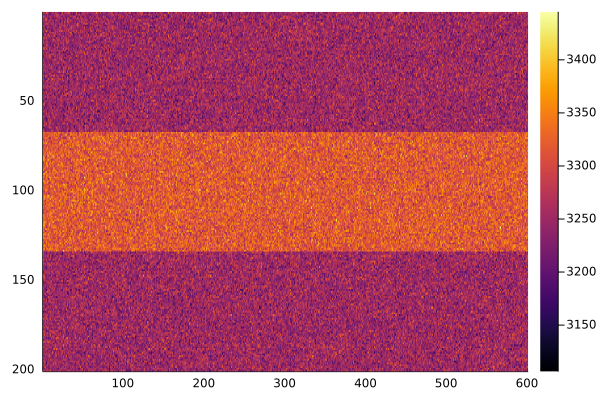

In [4]:
# look at vp of the medium, slice along y=ymean
heatmap(medium[:vp][:,div(ny,2),:], yflip=true)
# plot(ageom, SSrcs(),yflip=true)
# plot!(ageom, Recs())

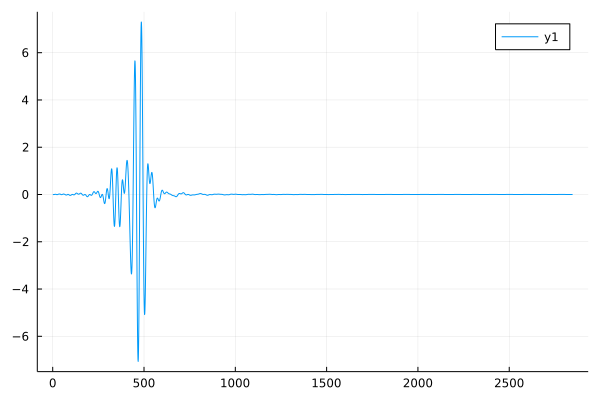

In [5]:

wav, tgrid=ormsby(medium, 12, 1,)
dt=step(tgrid)
function get_srcwav()
    # 8 wavelengths along the diagonal of the medium, and total time of 1 diagonal

    nts_perc=5.
    a=randn(floor(Int,length(tgrid)*nts_perc*0.01))
    wavv=DSP.conv(a,wav)[1:length(tgrid)]

    global freqmax=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:max)
    freqpeak=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:peak)
    freqmin=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:min)
    tmax=maximum(tgrid); nt=length(tgrid); 
#     println("nt:\t",length(tgrid))
#     println("freqpeak:\t",freqpeak)


    # intialize SrcWavelets
    srcwav = SrcWav(tgrid, ageom, [:vx])
    GeoPhyInv.update!(srcwav, [:vx], wavv)
    return srcwav
end
srcwav=get_srcwav()

plot(srcwav[1].d)

In [6]:
println("all possible fields: ",GeoPhyInv.Fields())

all possible fields: [:dpdx, :dpdy, :dpdz, :dtauxxdx, :dtauxydx, :dtauxydy, :dtauxzdx, :dtauxzdz, :dtauyydy, :dtauyzdy, :dtauyzdz, :dtauzzdz, :dvxdx, :dvxdy, :dvxdz, :dvydx, :dvydy, :dvydz, :dvzdx, :dvzdy, :dvzdz, :p, :tauxx, :tauxy, :tauxz, :tauyy, :tauyz, :tauzz, :vx, :vy, :vz]


In [7]:
# Data.Number
FD_ORDER=4
g=range(mgrid[1][1]-step(mgrid[1])*(FD_ORDER-1)*0.5, step=step(mgrid[1]), length=length(mgrid[1])+FD_ORDER-1)
println(collect(g[1:10]),"\n",collect(mgrid[1][1:10]), "\n",length(g), "\t", length(mgrid[1]))
# plot(g)
# plot!(mgrid[1])

# 
# length(mgrid[1])
# mgrid

[-22.5, -7.5, 7.5, 22.5, 37.5, 52.5, 67.5, 82.5, 97.5, 112.5]
[0, 15, 30, 45, 60, 75, 90, 105, 120, 135]
204	201


In [18]:
# typically you will this cell once
tsnaps=tgrid[1:div(length(tgrid),20):end] # store 20 snapshots
    rfields= [:vz,:vx,:vy]  # add as many fields are possible here to record
pa = SeisForwExpt(
#     FdtdAcou(),
    FdtdElastic(),
        snaps_field=:vz, # 
    tsnaps=tsnaps,
#     pml_edges=[:xmin, :xmax, :zmax, :ymin, :ymax], # if you want surface waves to be modelled
    pml_edges=[:xmin, :xmax, :zmax, :zmin, :ymin, :ymax], # absorbing BC on edges
    medium = medium,
    ageom = ageom,
rfields=rfields,
    srcwav = srcwav,
    sflags = [2],
    rflags = [1],
    tgrid = tgrid,
#     zfree = 0, # location of the stree-free boundary
    verbose = true,
);


┌ Info: frequency bounds for propagating wavefield 1 are: [0.00e+00, 2.06e+01], with peak at: 1.14e+01
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/updates.jl:142
┌ Info: spatial sampling (1.50e+01) can be as high as 1.79e+01
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:41


In [20]:
# do actual modeling
GeoPhyInv.update!(pa)

┌ Warning: Performing scalar indexing on task Task (runnable) @0x000015510851f0a0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/pawan/.julia/packages/GPUArrays/0vqbc/src/host/indexing.jl:56
	modeling supershot 1/1 100%|███████████████████████████| Time: 0:01:50


timer output of methods inside time loop
 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:             137s / 80.4%           9.34GiB / 90.0%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 advance time step      2.85k    63.1s  57.2%  22.2ms   6.42GiB  76.4%  2.31MiB
 record at receivers    2.85k    46.9s  42.5%  16.5ms   1.94GiB  23.0%   713KiB
 add source             2.85k    376ms  0.34%   132μs   50.7MiB  0.59%  18.2KiB
 ──────────────────────────────────────────────────────────────────────────────  


In [48]:
using DistributedArrays
vcat(localpart(pa.p)[1].ss[1].rindices...)

200×2×2 Array{CartesianIndex{3}, 3}:
[:, :, 1] =
 CartesianIndex(31, 53, 80)   CartesianIndex(31, 54, 80)
 CartesianIndex(32, 53, 80)   CartesianIndex(32, 54, 80)
 CartesianIndex(31, 53, 85)   CartesianIndex(31, 54, 85)
 CartesianIndex(32, 53, 85)   CartesianIndex(32, 54, 85)
 CartesianIndex(31, 53, 90)   CartesianIndex(31, 54, 90)
 CartesianIndex(32, 53, 90)   CartesianIndex(32, 54, 90)
 CartesianIndex(31, 53, 95)   CartesianIndex(31, 54, 95)
 CartesianIndex(32, 53, 95)   CartesianIndex(32, 54, 95)
 CartesianIndex(31, 53, 100)  CartesianIndex(31, 54, 100)
 CartesianIndex(32, 53, 100)  CartesianIndex(32, 54, 100)
 CartesianIndex(31, 53, 105)  CartesianIndex(31, 54, 105)
 CartesianIndex(32, 53, 105)  CartesianIndex(32, 54, 105)
 CartesianIndex(31, 53, 110)  CartesianIndex(31, 54, 110)
 ⋮                            
 CartesianIndex(31, 53, 536)  CartesianIndex(31, 54, 536)
 CartesianIndex(32, 53, 536)  CartesianIndex(32, 54, 536)
 CartesianIndex(31, 53, 541)  CartesianIndex(31, 54, 541)


┌ Info: Saved animation to 
│   fn = /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/tmp.gif
└ @ Plots /home/pawan/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/home/pawan/.julia/dev/GeoPhyInv/src/fdtd/tmp.gif")
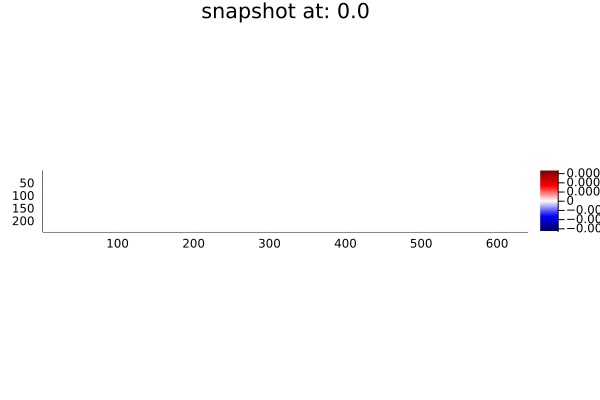

In [21]:
pmax=maximum([maximum(pa[:snaps][it]) for it in 1:length(tsnaps)])

    anim=@animate for it in 1:length(tsnaps)

    # Visualisation

        f=pa[:snaps,1][it]
        if(length(mgrid)==2)
           heatmap(f,         
            aspect_ratio = 1/3,
            xlims = (1, size(f,2)),
            ylims = (1, size(f,1)),
                yflip=true,
            c = :seismic,
            title = string("snapshot at: ",tsnaps[it]),
            clims = (-pmax, pmax),
        )
        else 
            heatmap(f[1:end, div(ny,2), 1:end],
            aspect_ratio = 1/3,
            xlims = (1, size(f,3)),
            ylims = (1, size(f,1)),
                yflip=true,
            c = :seismic,
            title = string("snapshot at: ",tsnaps[it]),
            clims = (-pmax, pmax),
        )

    end
    
end

gif(anim, fps=1)

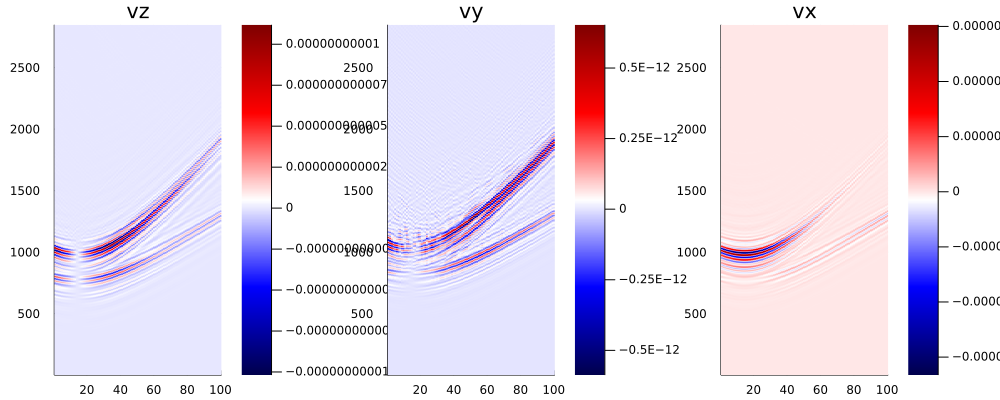

In [22]:
# gr()
# pa.c.pml[:x][:a][end-16:end]
p1=heatmap(pa[:data][:vz], title="vz", c=:seismic)
p2=heatmap(pa[:data][:vy], title="vy", c=:seismic)
p3=heatmap(pa[:data][:vx], title="vx", c=:seismic)

plot(p1,p2,p3, size=(1000,400), layout=(1,3))


In [ ]:
println("maximum freqneucy modelled\t", freqmax)
println("current sampling frequency \t",inv(dt))
println("we can subsample by a factor of \t",inv(dt)/2/freqmax)

In [ ]:
subsample_factor=10
nt_new=div(length(tgrid), subsample_factor)+1

In [ ]:
function generate_and_store_data(name)

    ageom=get_ageom()
    srcwav=get_srcwav()
    
	GeoPhyInv.update!(pa, ageom)
	GeoPhyInv.update!(pa, srcwav)

# 	GeoPhyInv.initialize!(pa.c)
# 	GeoPhyInv.update!(pa); # running the modelling

    # collect the data and resampling
    expt_name=string(randn())
    h5open(string(name,".h5"),isfile(string(name,".h5")) ? "r+" : "w") do file
        g=create_group(file, expt_name)
        for rf in rfields
        data=pa[:data,1][rf] # collect data at receivers from rfields
        datanew=zeros(nt_new,size(data,2))
        for i in 1:size(data,2)
            d=view(data,:,i)
            dd=view(datanew,:,i)
            ddd=resample(d,inv(subsample_factor))
            copyto!(dd,ddd)
        end
        datanew=datanew[21:270,:]
        ds=size(datanew)
        d=vec(datanew)
        rescale!(d)
        datanew=Float32.(reshape(d,ds...))
        # println(size(datanew))
            g[string(rf)] = datanew
        end
    end
end
# size(pa[:snaps,1])
# pa.c.itsnaps

In [ ]:
for i in 1:2
    generate_and_store_data("test_data")
end
# heatmap(datanew)